In [475]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_learning_curves
import scipy.stats as ss
from jcopml.tuning.space import Real, Integer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [520]:
# Definisi korelasi yang mungkin akan dipakai

#Correlation measurement untuk data discrete dan continous
def correlation_ratio(categories, measurement):
    fcat,_ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array, y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurement,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

#Correlation measurement untuk data discrete dan discrete
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [79]:
hotel = pd.read_csv('hotel_bookings.csv')
hotel = hotel.iloc[0:3001]

In [80]:
len(hotel.columns)

32

In [85]:
pd.DataFrame({'dataFeatures' : hotel.columns, 'dataType' : hotel.dtypes.values, 
              'null' : [hotel[i].isna().sum() for i in hotel.columns],
              'nullPct' : [((hotel[i].isna().sum()/len(hotel[i]))*100).round(2) for i in hotel.columns],
             'Nunique' : [hotel[i].nunique() for i in hotel.columns]})

,dataFeatures,dataType,null,nullPct,Nunique
0,hotel,object,0,0.00,1
1,is_canceled,int64,0,0.00,2
2,lead_time,int64,0,0.00,229
3,arrival_date_year,int64,0,0.00,1
4,arrival_date_month,object,0,0.00,5
5,arrival_date_week_number,int64,0,0.00,20
6,arrival_date_day_of_month,int64,0,0.00,31
7,stays_in_weekend_nights,int64,0,0.00,10
8,stays_in_week_nights,int64,0,0.00,18
9,adults,int64,0,0.00,14


In [86]:
categorical = hotel.select_dtypes('object').columns
numerical = hotel.drop(categorical, axis = 1).columns
categorical, numerical

(Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
        'distribution_channel', 'reserved_room_type', 'assigned_room_type',
        'deposit_type', 'customer_type', 'reservation_status',
        'reservation_status_date'],
       dtype='object'),
 Index(['is_canceled', 'lead_time', 'arrival_date_year',
        'arrival_date_week_number', 'arrival_date_day_of_month',
        'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
        'babies', 'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
        'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
        'total_of_special_requests'],
       dtype='object'))

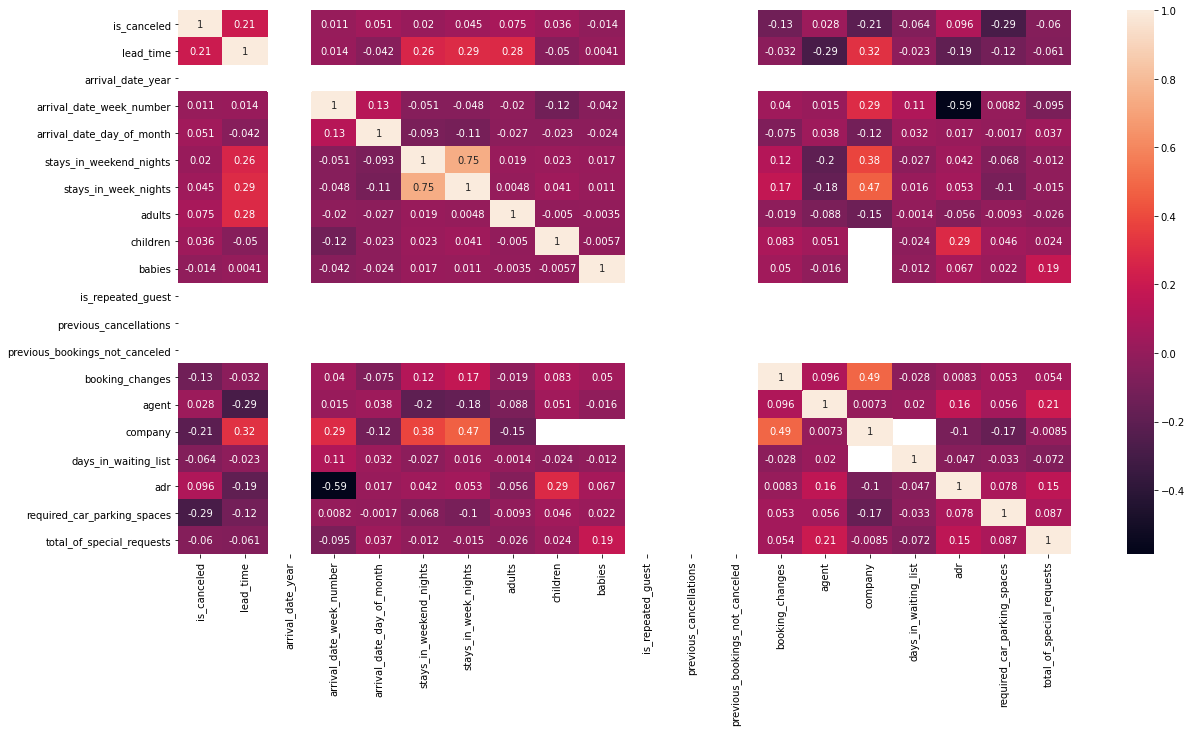

In [87]:
mat_corr = hotel[numerical].corr()
plt.figure(figsize = (20,10))
sns.heatmap(mat_corr, annot = True)

> Di Dataset ini <i>is_canceled</i> adalah targetnya. Dan hubungannya dengan numerik, dapat dilihat fitur <i>led_time, company, </i> dan <i> required_car_parking_spaces </i> punya korelasi. Namun memang tidak begitu kuat. Banyak korelasi yang bernilai <i>missing value</i>.

# Handling Missing Value

In [88]:
percentNa = []
lenNa = []

for i in hotel.columns:
    lenNa = hotel[i].isna().sum()
    percentNa.append((lenNa/len(hotel))*100)
    
dfNull = pd.DataFrame({'%null' : percentNa}, index = hotel.columns).sort_values(ascending = False, by = '%null').head(5)
dfNull['null'] = hotel.isna().sum()
dfNull

,%null,null
company,95.901366,2878
agent,15.494835,465
country,0.033322,1
hotel,0.000000,0
previous_cancellations,0.000000,0


> Dataset ini punya 3 fitur yang memiliki <i>missing value</i>. 

## Company

> Tabel di atas menunjukkan fitur <i> company </i> punya missing value di atas 50%. Artinya, jika saya mencoba mengisi <i> missing value </i> tersebut. Itu akan membuat dataset kita menjadi sangat bias. Maka saya putuskan untuk membuat fitur ini. 

In [89]:
hotel.drop('company', axis = 1, inplace = True)

In [90]:
percentNa = []
lenNa = []

for i in hotel.columns:
    lenNa = hotel[i].isna().sum()
    percentNa.append((lenNa/len(hotel))*100)
    
dfNull = pd.DataFrame({'%null' : percentNa}, index = hotel.columns).sort_values(ascending = False, by = '%null').head(5)
dfNull['null'] = hotel.isna().sum()
dfNull

,%null,null
agent,15.494835,465
country,0.033322,1
hotel,0.000000,0
is_repeated_guest,0.000000,0
reservation_status,0.000000,0


## agent

> Menurut deskripsi dataset, agent adalah sebuah id dari <i>travel agency</i>. Maka artinya angka-angka ini bukan sebuah numerik. Jadi saya putuskan untuk mengisinya dengan 0, yang dimana 0 artinya seseorang tidak mengisinya atau lupa mengisinya. 

In [95]:
hotel['agent'].fillna(0, inplace = True)

In [96]:
percentNa = []
lenNa = []

for i in hotel.columns:
    lenNa = hotel[i].isna().sum()
    percentNa.append((lenNa/len(hotel))*100)
    
dfNull = pd.DataFrame({'%null' : percentNa}, index = hotel.columns).sort_values(ascending = False, by = '%null').head(5)
dfNull['null'] = hotel.isna().sum()
dfNull

,%null,null
country,0.033322,1
hotel,0.000000,0
is_repeated_guest,0.000000,0
reservation_status,0.000000,0
total_of_special_requests,0.000000,0


## Country

> Pada fitur <i>country</i> memiliki satu <i>missing value</i>, saya bisa saja membuangnya. Namun saya lebih memilih buat mengisinya dengan nilai <i>country</i> yang punya frekuensi paling tinggi.

In [519]:
hotel['country'].value_counts().head(1)

PRT    1776
Name: country, dtype: int64

> PRT adalah data <i>country</i> yang punya frekuensi tertinggi. 

In [101]:
hotel.fillna(hotel['country'].value_counts()[0], inplace = True)

In [103]:
percentNa = []
lenNa = []

for i in hotel.columns:
    lenNa = hotel[i].isna().sum()
    percentNa.append((lenNa/len(hotel))*100)
    
dfNull = pd.DataFrame({'%null' : percentNa}, index = hotel.columns).sort_values(ascending = False, by = '%null').head(5)
dfNull['null'] = hotel.isna().sum()
dfNull

,%null,null
hotel,0.0,0
is_repeated_guest,0.0,0
reservation_status,0.0,0
total_of_special_requests,0.0,0
required_car_parking_spaces,0.0,0


> Dataset kita seharusnya sudah tidak terdapat <i>missing value</i> lagi. 

# Preprocessing

Untuk bagian preprocessing akan saya lakukan bersamaan di bagian <i>Model Building & Hyper-parameter Tuning</i>. Karena rencana saya, saya akan melakukan <i>feature selection</i> dan <i>feature scaling</i>.

# EDA

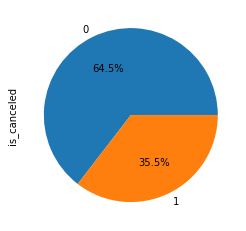

In [122]:
hotel['is_canceled'].value_counts().plot(kind = 'pie',autopct='%1.1f%%')

> Menurut paper yang dirujuk (https://www.sciencedirect.com/science/article/pii/S2352340918315191) nilai fitur <i>is_canceled</i>: <i>Value indicating if the booking was canceled (1) or not (0).</i> Artinya lebih sedikit terjadinya pembatalan daripada yang tidak melakukan pembatalan. Namun dataset masih belum memperlihatkan <i>imbalanced dataset.</i> 

In [124]:
hotel['hotel'].unique()

array(['Resort Hotel'], dtype=object)

> Di dataset ini, 100% semua orang mem-<i>booking</i> untuk <i>resort hotel.</i>

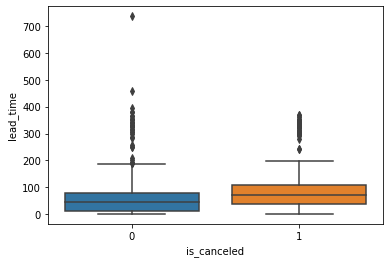

In [126]:
sns.boxplot(hotel['is_canceled'],hotel['lead_time'])

> Fitur <i>lead_time</i> adalah hari yang berlalu dari pemesanan dilakukan dan saat <i>check-in</i>. Dari <i>boxplot</i> di atas, terlihat bahwa rentang waktu pembatalan dengan pemesanan tidak terlalu jauh. Dimana dapat dilihat ada data meski sampai lewat 700 hari tidak adanya pembatalan. 

> <b>Insight: sebaiknya hotel punya kebijakan tersendiri dalam menangani data-data seperti orang yang dapat melakukan booking sampai di atas 700 hari. Seharusnya hotel punya sebuah <i>limit</i>, karena akan sangat merugikan hotel jika misalnya hotel telah menahan ruangan sampai 700 hari kemudian dibatalkan. Atau mungkin data di atas 700 hari ini, adalah orang yang penting atau memang orang yang telah berlangganan bertahun-tahun.</b>

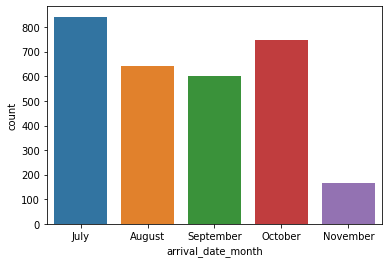

In [131]:
sns.countplot(hotel['arrival_date_month'])

> Bulan Juli adalah bulan yang paling tinggi terjadinya pemesanan hotel. Artinya juli adalah bulan dimana hotel akan sangat sibuk. Sebetulnya cukup mengagetkan melihat bulan November menjadi bulan terendah terjadinya pemesanan hotel, karena mengingat bulan desember akan punya banyak hari libur. Atau mungkin(?) orang-orang sudah jauh-jauh hari memesan hotel untuk bulan desember (bulan oktober misalnya). 

In [158]:
pd.crosstab(hotel['arrival_date_month'], hotel['is_canceled'])

is_canceled,0,1
arrival_date_month,,
August,331,312
July,599,243
November,114,52
October,498,250
September,395,207


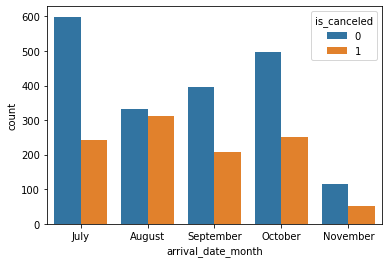

In [137]:
sns.countplot(hotel['arrival_date_month'], hue = hotel['is_canceled'])

> <b>Insight: Bulan Agustus menjadi bulan terbanyak terjadinya pembatalan. Itu kenapa, hotel harus lebih selektif di bulan ini. </b> 

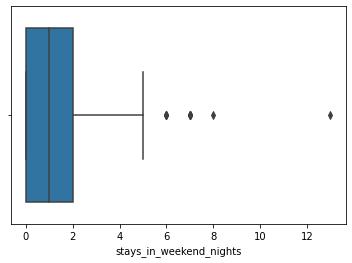

In [141]:
sns.boxplot(hotel['stays_in_weekend_nights'])

In [160]:
hotel[hotel['stays_in_weekend_nights'] > 12]['is_repeated_guest']

1655    0
Name: is_repeated_guest, dtype: int64

> Cukup asing melihat seseorang yang dapat menginap sampai lebih dari 12 minggu, namun bukan seseorang yang pernah atau sebelumnya menginap di hotel tersebut.

#  Model Building & Hyper-parameter Tuning

## Preprocessing

### Feature Selection

> Karena target pada dataset ini adalah <i>is_canceled</i>. Saya akan memperlihatkan bagaimana korelasi fitur <i>is_canceled</i> dengan fitur lainnya. Strategi saya adalah akan membuang fitur-fitur yang tidak punya korelasi kuat antar fitur <i>is_canceled</i> (dalam kasus ini korelasi yang di bawah 0.20).

##### Numerical

In [148]:
np.abs(mat_corr['is_canceled']).sort_values(ascending = False)

is_canceled                       1.000000
required_car_parking_spaces       0.287301
company                           0.210258
lead_time                         0.209328
booking_changes                   0.128946
adr                               0.095893
adults                            0.075263
days_in_waiting_list              0.063686
total_of_special_requests         0.059659
arrival_date_day_of_month         0.051030
stays_in_week_nights              0.045126
children                          0.035548
agent                             0.027768
stays_in_weekend_nights           0.019531
babies                            0.014396
arrival_date_week_number          0.010830
arrival_date_year                      NaN
is_repeated_guest                      NaN
previous_cancellations                 NaN
previous_bookings_not_canceled         NaN
Name: is_canceled, dtype: float64

> Fitur yang akan tetap tinggal: <i>required_car_parking_spaces, & lead_time.</i> <i>Company</i> tidak dipilih, karena telah dibuang di bagian <i>handling missing value</i>.             

###### Categorical

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


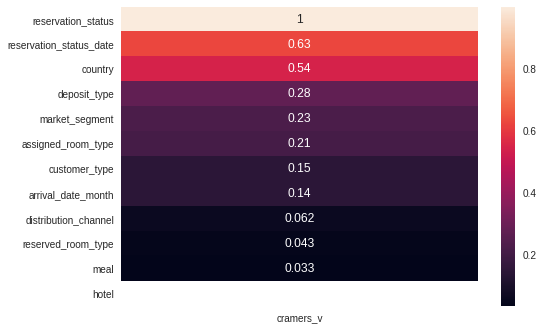

In [517]:
corrCat = []

for i in categorical:
        corrCat.append(cramers_v(hotel[i],hotel['is_canceled']))
        
dfcorr = pd.DataFrame(corrCat, index = categorical, columns = ['cramers_v']).sort_values(ascending = False, 
                                                                                              by = 'cramers_v')
sns.heatmap(dfcorr, annot = True)

In [157]:
hotel['reservation_status'].unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

> Fitur-fitut yang akan tetap tinggal: <i>reservation_status, reservation_status_date, country, deposit_type, market_segment, & assigned_room_type</i>

> <b>Insight: Masuk akal jika fitur <i>reservation_status</i> punya korelasi yang tinggi pada fitur <i>is_canceled</i>. Mengingat bahwa isi fiturnya adalah <i>Check-Out', Canceled, & No-Show</i>.

## Feature Scaling

Sebelum saya memilih <i>scaler</i> apa yang akan saya pilih, sebaiknya saya akan melihat terlebih dulu adanya outlier atau tidak di fitur-fitur. Mengingat saya tidak melakukan <i>outlier analysis</i> sebelumnya. 

In [162]:
out = []
Q1 = {}
Q3 = {}
IQR = {}
len_data_outlier = {}

for i in numerical.drop('company'):
    Q1[i] = hotel[i].describe()['25%']
    Q3[i] = hotel[i].describe()['75%']
    IQR[i] = Q3[i] - Q1[i]
    len_data_outlier[i] = len(hotel[(hotel[i] < Q1[i] - (1.5*IQR[i])) | (hotel[i] > Q3[i] + (1.5 * IQR[i]))])
    
for i,j in len_data_outlier.items():
    if j == 0:
        print('Tidak terdapat outliers di fitur {}'.format(i))
    else:
        print('Terdapat outliers di fitur {}'.format(i))
        out.append(i)

Tidak terdapat outliers di fitur is_canceled
Terdapat outliers di fitur lead_time
Tidak terdapat outliers di fitur arrival_date_year
Tidak terdapat outliers di fitur arrival_date_week_number
Tidak terdapat outliers di fitur arrival_date_day_of_month
Terdapat outliers di fitur stays_in_weekend_nights
Terdapat outliers di fitur stays_in_week_nights
Terdapat outliers di fitur adults
Terdapat outliers di fitur children
Terdapat outliers di fitur babies
Tidak terdapat outliers di fitur is_repeated_guest
Tidak terdapat outliers di fitur previous_cancellations
Tidak terdapat outliers di fitur previous_bookings_not_canceled
Terdapat outliers di fitur booking_changes
Tidak terdapat outliers di fitur agent
Terdapat outliers di fitur days_in_waiting_list
Terdapat outliers di fitur adr
Terdapat outliers di fitur required_car_parking_spaces
Terdapat outliers di fitur total_of_special_requests


> Dikarenakan fitur pada numerik yang akan kita gunakan adalah fitur: <i>required_car_parking_spaces & lead_time.</i> Maka dapat dilihat mereka punya outliers di dalamnya. Artinya scaler yang saya akan pilih adalah `RobustScaler()`.

In [267]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder

## Dataset Splitting

> Untuk menghindari data leakage, <i>scaling transformation</i> dilakukan setelah split. 

In [414]:
X = pd.get_dummies((hotel[['required_car_parking_spaces', 'lead_time', 'reservation_status', 'reservation_status_date', 'country', 'deposit_type', 'market_segment',
                      'assigned_room_type']]))
y = hotel['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2400, 292), (2400,), (601, 292), (601,))

In [415]:
robustScaler = RobustScaler()

    Membagi fitur numerik dan kategorikal.

In [416]:
X_trainNum = X_train[['required_car_parking_spaces', 'lead_time']]
X_trainCat = X_train.drop(['required_car_parking_spaces', 'lead_time'], axis = 1)

X_testNum = X_test[['required_car_parking_spaces', 'lead_time']]
X_testCat = X_test.drop(['required_car_parking_spaces', 'lead_time'], axis = 1)

    Lakukan scaling hanya ke fitur numerik.

In [417]:
X_trainNumSc = pd.DataFrame(robustScaler.fit_transform(X_trainNum), columns = ['required_car_parking_spaces', 'lead_time']
                         , index = X_trainNum.index)
X_testNumSc = pd.DataFrame(robustScaler.transform(X_testNum), columns = ['required_car_parking_spaces', 'lead_time']
                        ,index = X_testNum.index)

###### Dataset

    Digabungkannya fitur numerik yang sudah discaling dan fitur kategori.

In [418]:
X_trainSc = pd.concat([X_trainNumSc, X_trainCat], axis = 1)
X_testSc = pd.concat([X_testNumSc, X_testCat], axis = 1)
X_testSc.shape, X_trainSc.shape

((601, 292), (2400, 292))

In [483]:
X_trainSc.head()

,required_car_parking_spaces,lead_time,reservation_status_Canceled,reservation_status_Check-Out,reservation_status_No-Show,reservation_status_date_2014-11-18,reservation_status_date_2015-01-01,reservation_status_date_2015-01-02,reservation_status_date_2015-01-18,reservation_status_date_2015-01-22,...,market_segment_Online TA,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I
683,0.0,-0.078571,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1199,0.0,-0.564286,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
579,0.0,0.235714,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2877,0.0,-0.407143,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2453,1.0,-0.750000,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [490]:
X_testSc.head()

,required_car_parking_spaces,lead_time,reservation_status_Canceled,reservation_status_Check-Out,reservation_status_No-Show,reservation_status_date_2014-11-18,reservation_status_date_2015-01-01,reservation_status_date_2015-01-02,reservation_status_date_2015-01-18,reservation_status_date_2015-01-22,...,market_segment_Online TA,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I
45,0.0,-0.078571,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
668,0.0,-0.592857,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1650,0.0,0.850000,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1247,0.0,-0.235714,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
18,0.0,-0.750000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Training

Model-model yang saya pilih adalah:

* Logistic Regression
* Random Forest Classifier
* XGBoost Classifier

    Saya akan memulai dari model paling sederhana (default), kemudian akan dilanjutkan dengan tuning menggunakan RandomizedSearchCV

In [419]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [420]:
logreg = LogisticRegression(random_state = 101)
rfc = RandomForestClassifier(random_state = 101)
xgb = XGBClassifier(random_state = 101)

### Logistic regression

In [421]:
logreg.fit(X_trainSc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=101, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Evaluation

In [422]:
from sklearn.model_selection import cross_val_score

###### Cross-val-Score

In [434]:
scoreTrain = cross_val_score(logreg, X_trainSc, y_train, cv = 5)
print(scoreTrain.mean())

1.0


In [436]:
scoreTest = cross_val_score(logreg, X_testSc, y_test, cv = 5)
print(scoreTest.mean())

1.0


> Logistic Regression berhasil menebak dengan sempurna. 

In [437]:
from sklearn.metrics import classification_report, confusion_matrix

In [438]:
y_pred = logreg.predict(X_testSc)
confusion_matrix(y_test, y_pred)

array([[406,   0],
       [  0, 195]])

In [439]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       195

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



In [440]:
y_pred_train = logreg.predict(X_trainSc)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00       869

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



/home/user/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/learning_curves.py:132: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

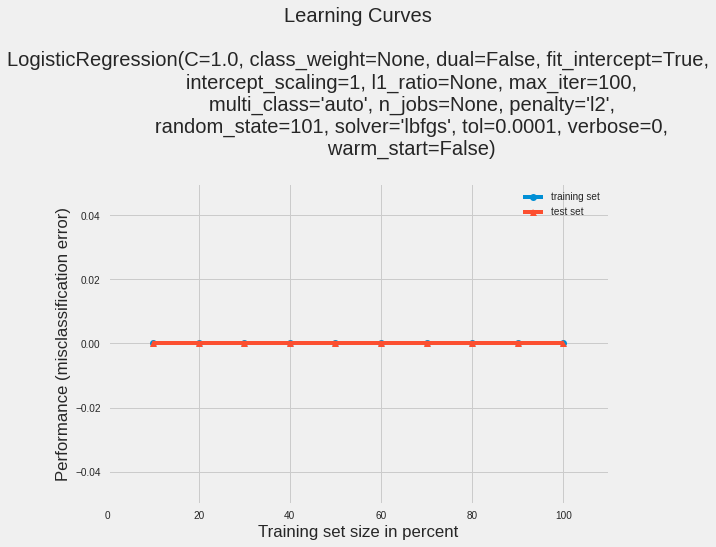

In [442]:
plot_learning_curves(X_trainSc, y_train, X_testSc, y_test, logreg)

> Learning Curve yang memiliki gap besar biasanya mengalami <i>overfitting</i> namun dalam kasus ini, tidak ada error sedikitpun. Dan juga stabil.

> Sejujurnya saya tidak tau kenapa classifier saya benar-benar dapat menebak dengan sangat amat baik. Namun tebakan saya, ini terjadi dikarenakan data yang terlalu kecil (terlalu kecil untuk fitur sebanyak dataset ini). Data yang terlalu kecil biasanya mudah diklasifikasi atau diprediksi oleh model. Seharusnya tuning tidak lagi diperlukan. 

#### Hyperparameter Tuning

In [488]:
from sklearn.model_selection import RandomizedSearchCV

> Dalam melakukan tuning di logistic regression, saya menggunakan regularisasi parameter diantar 0.0001 sampai 10000 (cukup fair dalam melakukan <i>penalty</i>) dan juga untuk parameter fit_intercept. 

    prior = 'log-uniform', memiliki logaritma berbasis 10

In [461]:
logreg_params = {
    'fit_intercept': [True, False],
    'C': Real(low=-3, high=3, prior='log-uniform')
}

> Saya menggunakan scoring 'f1' mengingat bahwa ini adalah permasalahan klasifikasi.

In [469]:
logreg_random = RandomizedSearchCV(estimator = logreg, param_distributions = logreg_params, 
                                scoring='f1', cv = 5,random_state = 101)

logreg_random.fit(X_trainSc, y_train)
print(logreg_random.best_params_)
print(logreg_random.score(X_trainSc, y_train), logreg_random.score(X_testSc, y_test))

{'C': 1.2542721123427771, 'fit_intercept': False}
1.0 1.0


In [470]:
logreg_tuned = logreg_random.best_estimator_

In [472]:
y_pred_tuned = logreg_tuned.predict(X_testSc)
confusion_matrix(y_test, y_pred_tuned)

array([[406,   0],
       [  0, 195]])

In [473]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       195

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



/home/user/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/learning_curves.py:132: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

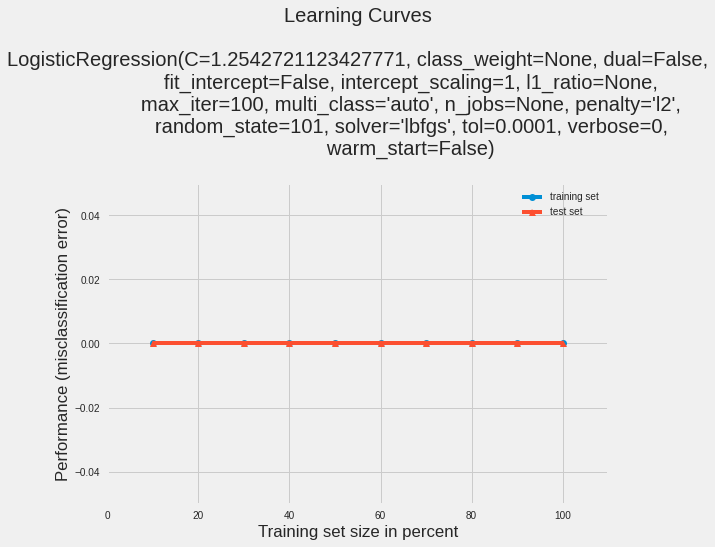

In [474]:
plot_learning_curves(X_trainSc, y_train, X_testSc, y_test, logreg_tuned)

> Learning Curve juga masih menunjukan klasifikasi yang sempurna.

### Random Forest Classifier

In [443]:
rfc.fit(X_trainSc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [444]:
scoreTrainRF = cross_val_score(rfc, X_trainSc, y_train)
print(scoreTrainRF.mean())

1.0


In [445]:
scoreTestRF = cross_val_score(rfc, X_testSc, y_test)
print(scoreTestRF.mean())

1.0


In [447]:
y_pred_rfc = rfc.predict(X_testSc)
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       195

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



In [449]:
y_pred_rfc_train = rfc.predict(X_trainSc)
print(classification_report(y_train, y_pred_rfc_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00       869

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



/home/user/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/learning_curves.py:132: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

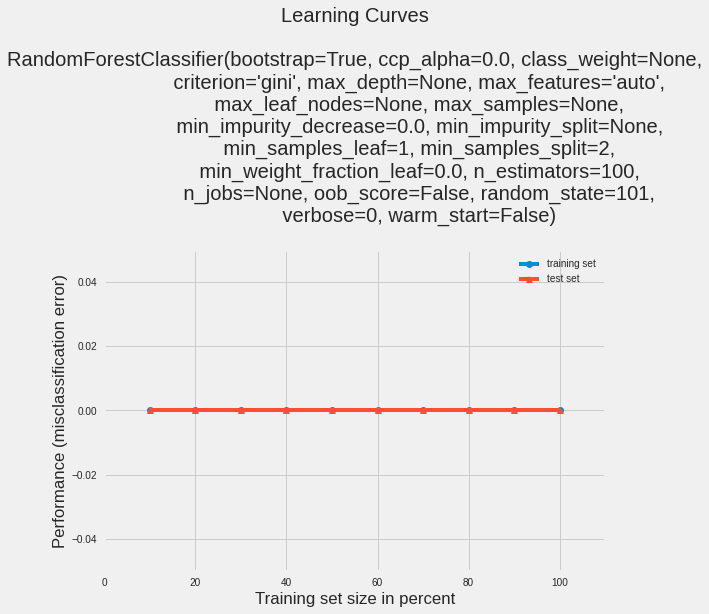

In [486]:
plot_learning_curves(X_trainSc, y_train, X_testSc, y_test, rfc)

##### Hyperparameter Tuning

> Max_depth yang kecil dapat membuat model menjadi tidak kompleks yang artinya dapat mencegah terjadinya overfitting. 

In [477]:
rf_params = {
    'n_estimators': Integer(low=100, high=200),
    'max_depth': Integer(low=20, high=50),
    'min_samples_leaf': Integer(low=1, high=20)
}

In [478]:
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = rf_params, 
                                scoring='f1', cv = 5,random_state = 101)

rfc_random.fit(X_trainSc, y_train)
print(rfc_random.best_params_)
print(rfc_random.score(X_trainSc, y_train), rfc_random.score(X_testSc, y_test))

{'max_depth': 28, 'min_samples_leaf': 1, 'n_estimators': 105}
1.0 1.0


In [480]:
rfc_tuned = rfc_random.best_estimator_

In [481]:
y_pred_rfc_tuned = rfc_tuned.predict(X_testSc)
print(classification_report(y_test, y_pred_rfc_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       195

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



In [485]:
y_pred_rfc_tuned = rfc_tuned.predict(X_trainSc)
print(classification_report(y_train, y_pred_rfc_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00       869

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



/home/user/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/learning_curves.py:132: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

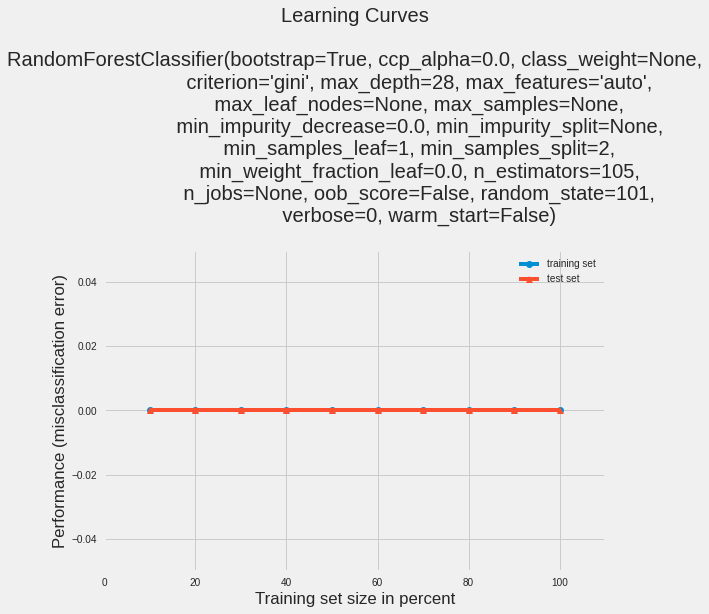

In [487]:
plot_learning_curves(X_trainSc, y_train, X_testSc, y_test, rfc_tuned)

> Kembali lagi, evaluasi tidak memperlihatkan adanya error ataupun overfitting ataupun underfitting. Masih memperlihatkan klasifikasi yang sempurna. 

#### XGBClassifier

In [489]:
xgb.fit(X_trainSc, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=101, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [491]:
scoreTrainXG = cross_val_score(xgb, X_trainSc, y_train)
print(scoreTrainXG.mean())

1.0


In [492]:
scoreTestXG = cross_val_score(xgb, X_testSc, y_test)
print(scoreTestXG.mean())

1.0


In [493]:
y_pred_xgb = xgb.predict(X_testSc)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       195

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



In [495]:
y_pred_xgb_train = xgb.predict(X_trainSc)
print(classification_report(y_train, y_pred_xgb_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00       869

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



/home/user/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/learning_curves.py:132: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

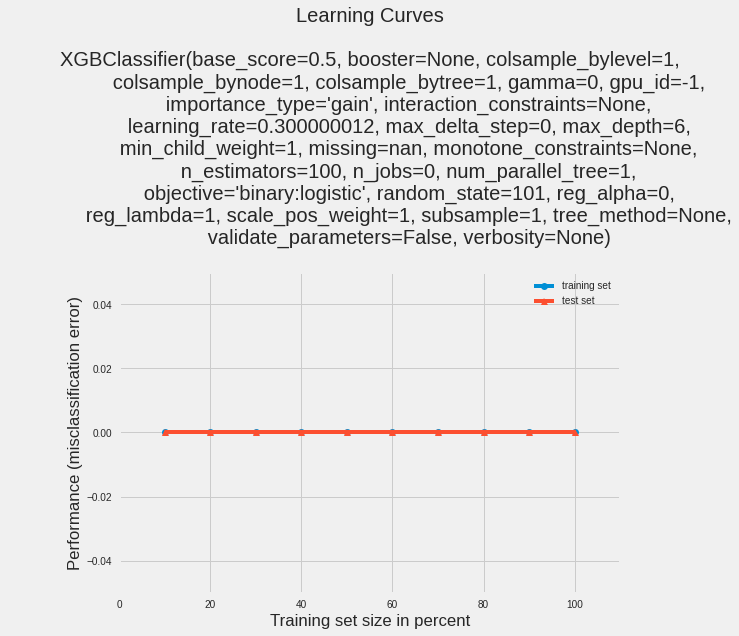

In [501]:
plot_learning_curves(X_trainSc, y_train, X_testSc, y_test, xgb)

##### Hyperparameter Tuning

> Parameter pada xgb lebih menarik, mengingat dia punya parameter regularisasi (alpha dan lambda) yang dapat mengurangi adanya overfitting. Mengingat jawaban di atas teramat baik, maka saya rasa tidak perlu banyak parameter yang dituning. Diulangi lagi, <i>Prior = log-uniform</i> di sini logaritma berbasis 10.

In [496]:
xgb_params = {
    'algo__max_depth': Integer(low=1, high=10),
    'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
    'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')
}

In [497]:
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = xgb_params, 
                                scoring='f1', cv = 5,random_state = 101)

xgb_random.fit(X_trainSc, y_train)
print(xgb_random.best_params_)
print(xgb_random.score(X_trainSc, y_train), xgb_random.score(X_testSc, y_test))

{'algo__max_depth': 2, 'algo__reg_alpha': 6.4675148102196705, 'algo__reg_lambda': 8.665436787939829}
1.0 1.0


In [498]:
xgb_tuned = xgb_random.best_estimator_

In [500]:
y_pred_xgb_tuned = xgb_tuned.predict(X_testSc)
print(classification_report(y_test, y_pred_xgb_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       195

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



In [502]:
y_pred_xgb_tuned = xgb_tuned.predict(X_trainSc)
print(classification_report(y_train, y_pred_xgb_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00       869

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



/home/user/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/learning_curves.py:132: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])


([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

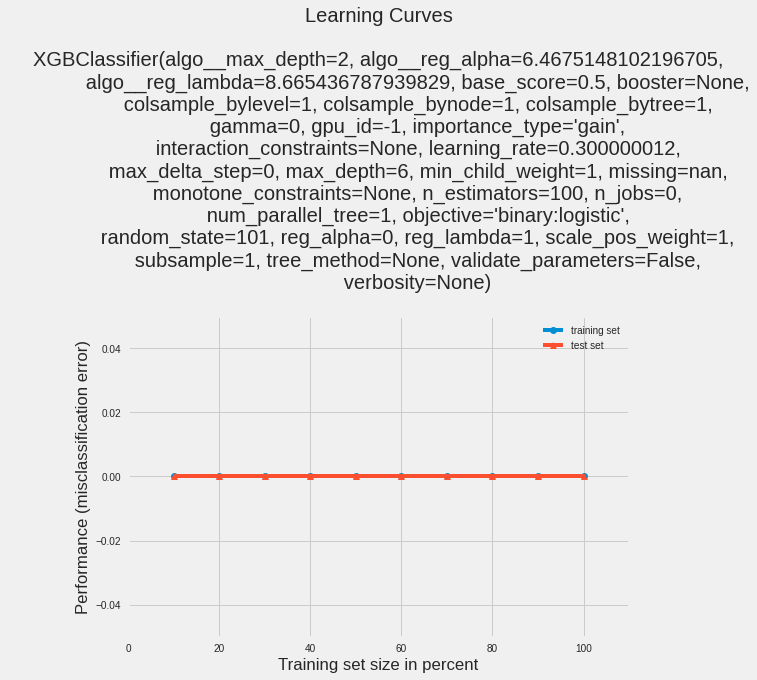

In [503]:
plot_learning_curves(X_trainSc, y_train, X_testSc, y_test, xgb_tuned)

# Model Evaluation

> Dapat disimpulkan bahwa semua classifier berkerja teramat baik. Yang dimana, tebakan saya tadi adalah fitur ini terlalu banyak namun dataset terlalu kecil. Jadi artinya model di atas sama baiknya. 

> Namun secara ide bisnis, model yang dipilih seharusnya model yangg memiliki recall tinggi. Mengingat reall yang tinggi artinya False Negative yang rendah. Dimana kita memprediksi dia cancel padahal tidak mau cancel. Itu sebuah masalah akan menimbulkan kerugian. Menebak seseorang akan melakukan cancel padahal tidak. 

Sebenarnya jika, hasil di atas tidak sebagus itu, saya ingin melakukan plot precision-recall. Dimana saya bisa mengganti threshold untuk memilih threshold yang kita ingini. Recall yang tinggi misalnya, biasanya memiliki threshold yang rendah. 

In [510]:
from sklearn.metrics import precision_recall_curve


def find_thresh(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)
    y_proba = y_proba[:,1]
    prec, recall, thresh = precision_recall_curve(y_test, y_proba)
    fScore = (2 * prec * recall) / (prec + recall)
    idx = np.argmax(fScore)
    
    ##plot
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Curve")
    plt.plot(thresh, prec[:-1], "b-", label="Precision")
    plt.plot(thresh, recall[:-1], "r-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
    return ('Best Threshold={}, F-Score={}'.format(thresh[idx], fScore[idx]))

##### Logistic Regression

'Best Threshold=0.909237816335482, F-Score=1.0'

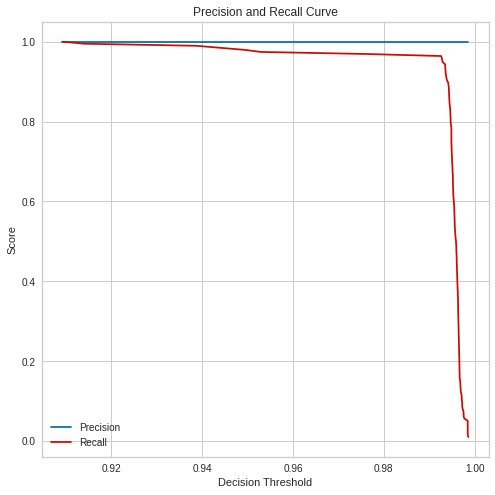

In [512]:
find_thresh(logreg_tuned, X_testSc, y_test)

#### Random Forest Classifier

'Best Threshold=0.7096596214243274, F-Score=1.0'

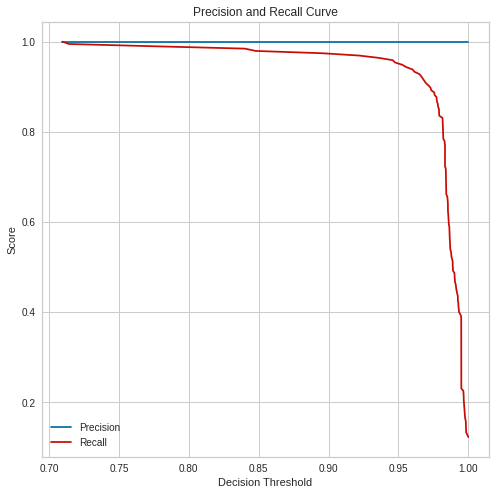

In [513]:
find_thresh(rfc_tuned, X_testSc, y_test)

### XGB Classifier

'Best Threshold=0.998803973197937, F-Score=1.0'

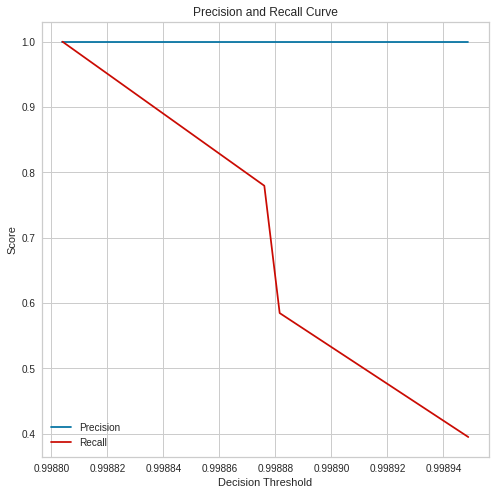

In [514]:
find_thresh(xgb_tuned, X_testSc, y_test)

> Dapat dilihat bahwa threshold yang rendah membuat reall semakin tinggi, namun dalam precision recall curve di atas, semua menunjukkan yang sama, precision yang terus tinggi. Yang artinya model kita dengan sangat amat baik menebak True Positive (TP), karena False Negative (FN) dan True Positive (TP) trade-off. Dan juga precision recall curve kita dimulai dari 0.99 yang artinya threshold selain di gambar ini tidaklah terlalu berbeda. 